# Description

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

To learn how to handle large datasets with ease and solve this problem using TensorFlow, consider taking the Machine Learning with TensorFlow on Google Cloud Platform specialization on Coursera -- the taxi fare problem is one of several real-world problems that are used as case studies in the series of courses. To make this easier, head to Coursera.org/NEXTextended to claim this specialization for free for the first month!

### Evaluation 

The evaluation metric for this competition is the root mean-squared error or RMSE. RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

## File descriptions

* train.csv - Input features and target fare_amount values for the training set (about 55M rows).
* test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.
* sample_submission.csv - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.

## Data fields

### ID

* key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

### Features 

* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
* passenger_count - integer indicating the number of passengers in the taxi ride.

### Target 

* fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

# 0. Import libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn 
import warnings
from math import *
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100) 

In [42]:
#PLOTLY
import plotly
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
from plotly.graph_objs import Scatter, Figure, Layout
cf.set_config_file(offline=True)

# 1. Preprocessing and EDA

Since there are a lot of rows, we will limit the dataframe to 500,000 rows for our case.

In [43]:
df = pd.read_csv('train.csv',nrows = 1000000)

In [44]:
df.head()

key  fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319         -73.841610         40.712278                1
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303         -73.979268         40.782004                1
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270         -73.991242         40.750562                2
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143         -73.991567         40.758092                1
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008         -73.956655         40.783762                1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null object
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [6]:
# Check for duplicates
df['key'].duplicated().sum()

0

## Missing and zero values 

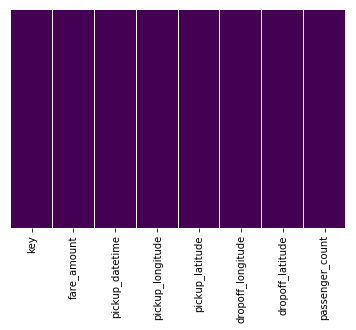

In [7]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [45]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

dropoff_longitude    10
dropoff_latitude     10
dtype: int64

There are 10 missing values for dropoff lon and lat. In comparison to the amount of rows, we can simply drop these rows.

In [46]:
df.dropna(axis=0, how='any', inplace=True)

In [47]:
# check the remaining df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999990 entries, 0 to 999999
Data columns (total 8 columns):
key                  999990 non-null object
fare_amount          999990 non-null float64
pickup_datetime      999990 non-null object
pickup_longitude     999990 non-null float64
pickup_latitude      999990 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      999990 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 68.7+ MB


In [48]:
# Convert pickup datetime object to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

#### Zero values

In case there are zero values for pickup_longitude, pickup_latitude, dropoff_longitude and dropoff_latitude, these indicate missing values. Therefore, we will see if there are zero values and if so, we will drop these rows.

In [49]:
# See if there are zero values that shouldn't be there
df[(df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0) | (df['dropoff_longitude'] == 0) | (df['dropoff_longitude'] == 0)]

key  fare_amount     pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count
11       2012-12-24 11:24:00.00000098          5.5 2012-12-24 11:24:00          0.000000         0.000000           0.000000          0.000000                3
15      2013-11-23 12:57:00.000000190          5.0 2013-11-23 12:57:00          0.000000         0.000000           0.000000          0.000000                1
26      2011-02-07 20:01:00.000000114          6.5 2011-02-07 20:01:00          0.000000         0.000000           0.000000          0.000000                1
124      2013-01-17 17:22:00.00000043          8.0 2013-01-17 17:22:00          0.000000         0.000000           0.000000          0.000000                2
192      2010-09-05 17:08:00.00000092          3.7 2010-09-05 17:08:00          0.000000         0.000000           0.000000          0.000000                5
233       2011-07-24 01:14:35.0000002          8.5 2011-07-24 01:14:35          0.000000         0.000000           0.000000          0.000000                2
273      2009-10-30 18:13:00.00000021          8.1 2009-10-30 18:13:00          0.000000         0.000000           0.000000          0.000000                4
357       2013-07-04 16:41:27.0000002          8.5 2013-07-04 16:41:27          0.000000         0.000000           0.000000          0.000000                1
376       2014-05-29 05:57:22.0000001          2.5 2014-05-29 05:57:22          0.000000         0.000000           0.000000          0.000000                1
387      2012-11-15 08:39:00.00000095         13.0 2012-11-15 08:39:00          0.000000         0.000000           0.000000          0.000000                1
472     2009-02-22 22:48:00.000000130          2.5 2009-02-22 22:48:00          0.000000         0.000000         -74.005433         40.726685                2
498       2009-03-16 04:47:17.0000001         17.0 2009-03-16 04:47:17          0.000000         0.000000           0.000000          0.000000                1
540       2013-10-29 01:09:14.0000002         16.0 2013-10-29 01:09:14          0.000000         0.000000           0.000000          0.000000                1
542     2009-12-29 14:23:00.000000158          4.5 2009-12-29 14:23:00          0.000000         0.000000           0.000000          0.000000                1
568       2014-10-08 06:49:18.0000001          6.5 2014-10-08 06:49:18          0.000000         0.000000           0.000000          0.000000                1
660       2010-08-18 03:46:00.0000002         13.3 2010-08-18 03:46:00          0.000000         0.000000           0.000000          0.000000                5
728       2010-02-13 01:52:11.0000003         11.7 2010-02-13 01:52:11          0.000000         0.000000           0.000000          0.000000                1
799      2013-12-08 23:39:00.00000080          3.0 2013-12-08 23:39:00          0.000000         0.000000           0.000000          0.000000                5
872     2011-09-25 02:07:00.000000139          8.5 2011-09-25 02:07:00          0.000000         0.000000           0.000000          0.000000                1
881       2011-07-19 23:43:12.0000001          8.5 2011-07-19 23:43:12          0.000000         0.000000           0.000000          0.000000                1
887       2014-09-26 19:41:41.0000004         12.0 2014-09-26 19:41:41          0.000000         0.000000           0.000000          0.000000                1
958      2011-02-22 14:09:00.00000066          2.5 2011-02-22 14:09:00          0.000000         0.000000           0.000000          0.000000                5
960       2013-05-31 05:02:30.0000001         12.5 2013-05-31 05:02:30          0.000000         0.000000           0.000000          0.000000                1
964       2009-06-30 10:20:09.0000005         14.1 2009-06-30 10:20:09          0.000000         0.000000           0.000000          0.000000                1
966       2015-06-08 01:59:17.0000

In [50]:
# Create new dataframe where the 0 values are dropped
df = df.drop(df[(df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0) | (df['dropoff_longitude'] == 0) | (df['dropoff_longitude'] == 0)].index)

# Outlier removal

We will check the following features:
* pickup_longitude
* pickup_latitude
* dropoff_longitude
* dropoff_latitude
* passenger_count

### Pickup longitude 

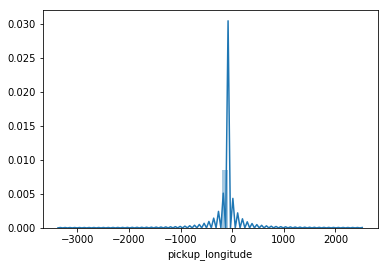

In [51]:
sns.distplot(df['pickup_longitude'])

In [52]:
df['pickup_longitude'].mean()

-73.91435753858858

Based on information of the internet, the longitude of NYC is -73.935242. So the mean is roughly the same.

In [16]:
df['pickup_longitude'].max()

2522.271325

In [17]:
df['pickup_longitude'].min()

-3377.6809350000003

The min and the max values of pickup longitude are very widespread. 
One degree of longitude is roughly 111 kilometers. Therefore, we will plus and minus 2 degrees of longitude from the average.

Since the taxi rides are in and around NYC, we will remove all rows where the pickup_longitude is below -72 and above -76.

In [53]:
df = df[(df['pickup_longitude']<-72) & (df['pickup_longitude']>-76)]

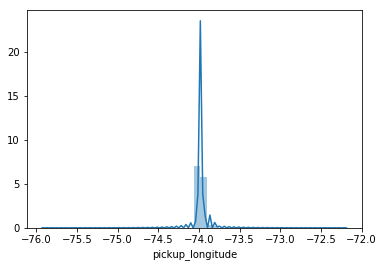

In [54]:
sns.distplot(df['pickup_longitude'])

### Pickup latitude  

The latitiude of NYC is 40.730610. Therefore, we will remove rows above 43 and below 39.

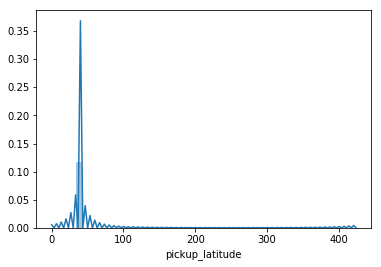

In [55]:
sns.distplot(df['pickup_latitude'])

In [56]:
df['pickup_latitude'].mean()

40.752281116649236

In [59]:
df = df[(df['pickup_latitude']<43) & (df['pickup_latitude']>39)]

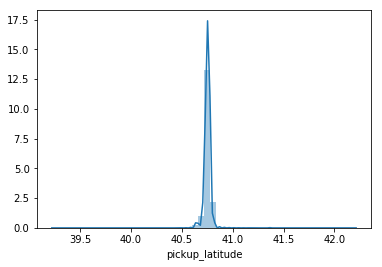

In [62]:
sns.distplot(df['pickup_latitude'])

### Dropoff longitude 

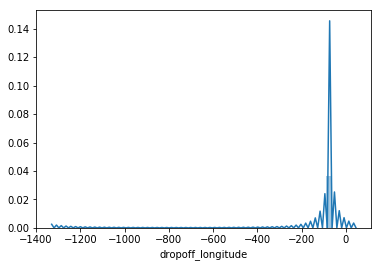

In [63]:
sns.distplot(df['dropoff_longitude'])

In [64]:
df['dropoff_longitude'].mean()

-73.97585819760266

In [65]:
df['dropoff_longitude'].min()

-1329.621332

We will do the same as for the pickup longitude.

In [66]:
df = df[(df['dropoff_longitude']<-72) & (df['dropoff_longitude']>-76)]

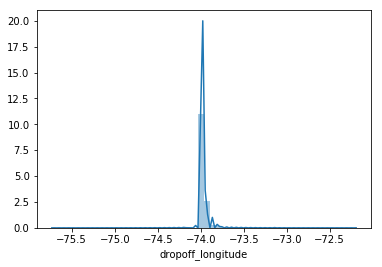

In [67]:
sns.distplot(df['dropoff_longitude'])

### Dropoff latitude 

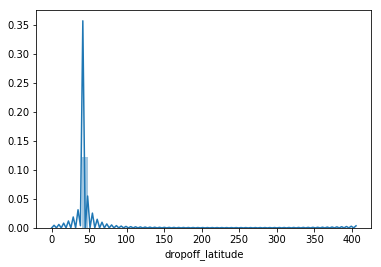

In [68]:
sns.distplot(df['dropoff_latitude'])

In [69]:
df['dropoff_latitude'].mean()

40.75237028116802

In [70]:
df = df[(df['dropoff_latitude']<43) & (df['dropoff_latitude']>39)]

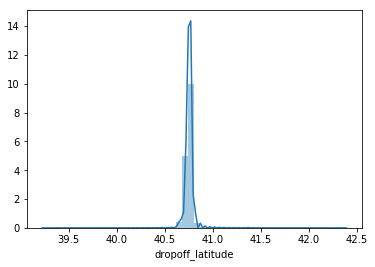

In [71]:
sns.distplot(df['dropoff_latitude'])

### Passenger count 

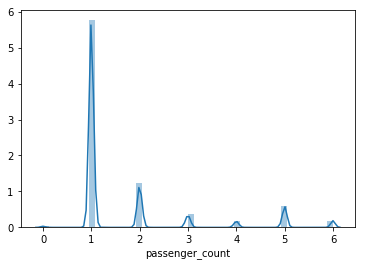

In [72]:
sns.distplot(df['passenger_count'])

In [74]:
df['passenger_count'].max()

6

There seems to be no outliers for the passenger count.

--------------------------------------------------------------------------------

### Pickup datetime

In [76]:
df['pickup_datetime'].min()

Timestamp('2009-01-01 00:00:46')

In [77]:
df['pickup_datetime'].max()

Timestamp('2015-06-30 23:53:49')

## Visualization

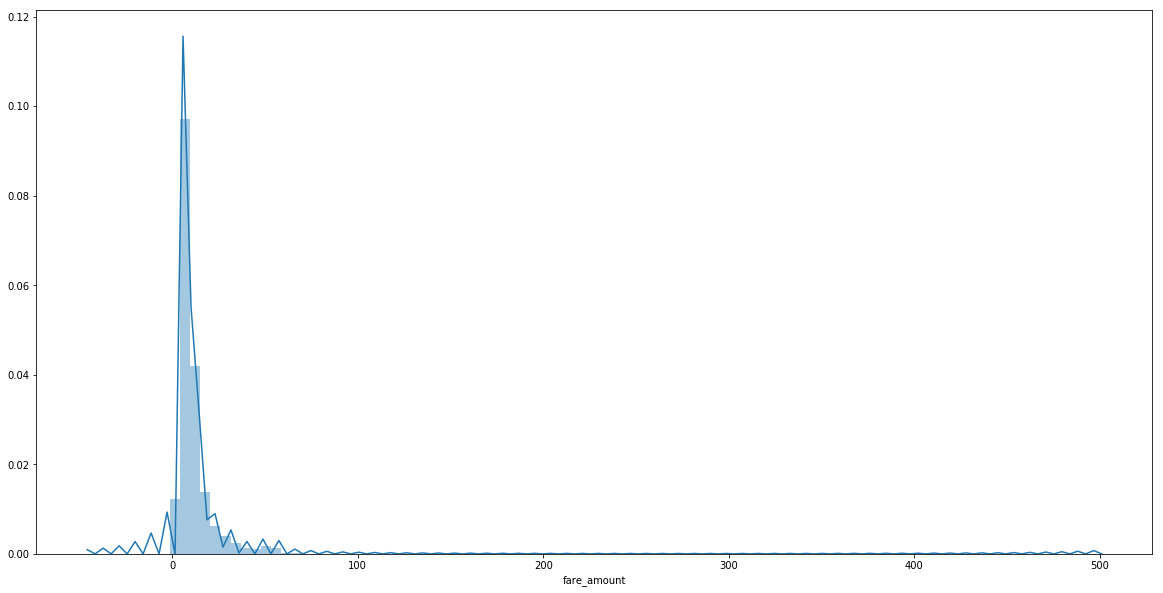

In [79]:
# Fare amount distribution
plt.figure(figsize=(20,10))
sns.distplot(df['fare_amount'],bins=100)

There is a very long right tail for the fare amount distribution. We could either do two things: remove the fare amounts outside the IQR or we could log-transform the distribution.

First, we will remove the negative and zero values of fare amounts.

In [90]:
df = df.drop(df[df['fare_amount']<=0].index)

### IQR fare amount 

In [96]:
q1, q3= np.percentile(df.fare_amount,[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * q1)
upper_bound = q3 + (1.5 * q3)
print("Lower bound of fare amount: " + str(lower_bound))
print("Upper bound of fare amount: " + str(upper_bound))

Lower bound of fare amount: -3.0
Upper bound of fare amount: 31.25


In [97]:
# check amount of rows inside the upper bound of IQR for fare amount
rows_inside_upperbound = df[df['fare_amount']<=upper_bound].count()
print(rows_inside_upperbound)

key                  933557
fare_amount          933557
pickup_datetime      933557
pickup_longitude     933557
pickup_latitude      933557
dropoff_longitude    933557
dropoff_latitude     933557
passenger_count      933557
dtype: int64


In [98]:
# check amount of rows outside the upper bound of IQR for fare amount
rows_outside_upperbound = df[df['fare_amount']>upper_bound].count()
print(rows_outside_upperbound)

key                  45847
fare_amount          45847
pickup_datetime      45847
pickup_longitude     45847
pickup_latitude      45847
dropoff_longitude    45847
dropoff_latitude     45847
passenger_count      45847
dtype: int64


In [99]:
perc_outliers = (rows_outside_upperbound.key / (rows_outside_upperbound.key + rows_inside_upperbound.key))*100
print('Percentage rows outside the upperbound of IQR ' + str(round(perc_outliers,2)) + '%')

Percentage rows outside the upperbound of IQR 4.68%


We will remove the rows outside the upper bound of the IQR.

In [100]:
df = df.drop(df[df['fare_amount']>31.25].index)

### Log-transform fare_amount

Skewness: 1.544957


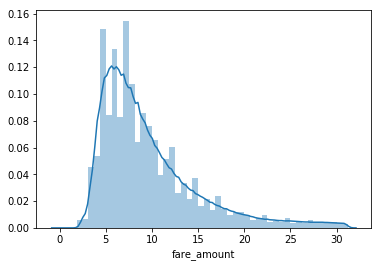

In [104]:
# Plot distribution of target variable: fare_amount
sns.distplot(df['fare_amount']);
#skewness
print("Skewness: %f" % df['fare_amount'].skew())

In [114]:
df['fare_amount_Log'] = np.log(df['fare_amount'])

Check for NaN values in fare_amount_Log.

In [115]:
df['fare_amount_Log'].isna().sum()

0

-------------------------------------------------------------------------------------

Skewness: 0.314086


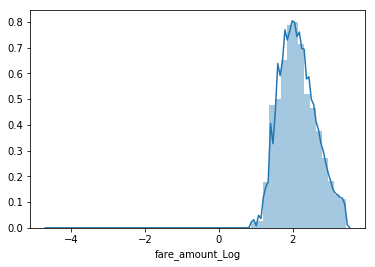

In [116]:
# Plot distribution of target variable: fare_amount_log
sns.distplot(df['fare_amount_Log']);
#skewness
print("Skewness: %f" % df['fare_amount_Log'].skew())

The distribution now approaches a normal distribution after log-transforming it.

#### Pickup locations 

In [24]:
df_temp = df.iloc[:5000]

In [25]:
data = [go.Scattermapbox(
            lat= df_temp['pickup_latitude'] ,
            lon= df_temp['pickup_longitude'],
            customdata = df_temp['key'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'blue',
                opacity = .8,
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken="pk.eyJ1Ijoic2hhejEzIiwiYSI6ImNqYXA3NjhmeDR4d3Iyd2w5M2phM3E2djQifQ.yyxsAzT94VGYYEEOhxy87w",
                                bearing=10,
                                pitch=60,
                                zoom=13,
                                center= dict(
                                         lat=40.721319,
                                         lon=-73.987130),
                                style = 'dark'
                                ),
                    width=900,
                    height=600, title = "Pick up Locations")

In [26]:
fig = dict(data=data, layout=layout)
iplot(fig)

# Feature engineering 

In [117]:
# Transform pickup data into day of the week, hour of the day, et cetera
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.weekday
df['hour'] = df['pickup_datetime'].dt.hour

In [118]:
# group hour of the day into morning, afternoon, evening and night

# Create a list to store the data
dayparts = []

# For each row in the column,
for row in df['hour']:
    # if more than a value,
    if row in range(6,12):
        # Append a daypart
        dayparts.append('morning')
    # else, if more than a value,
    elif row in range(12,18):
        # Append a daypart
        dayparts.append('afternoon')
    elif row in range(18,24):
        # Append a daypart
        dayparts.append('evening')
# otherwise,
    else:
        dayparts.append('night')
        
# Create a column from the list
df['dayparts'] = dayparts

In [119]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',3: 'Thursday',4: 'Friday',5: 'Saterday',6: 'Sunday'}
df['day'] = df['day'].map(day_mapping)

In [120]:
# Group months into seasons.
# First create an empty list
season = []

# For each row in the column,
for row in df['month']:
    if row in range(3,6):
        season.append('spring')

    elif row in range(6,9):
        season.append('summer')
        
    elif row in range(9,12):
        season.append('fall')    
# otherwise,
    else:
        season.append('winter')
        
# Create a column from the list
df['season'] = season

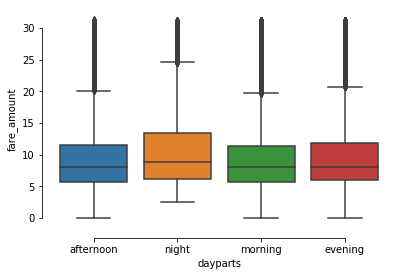

In [124]:
# Boxplot of the month and days_in_from_status_Log
sns.boxplot(x="dayparts", y="fare_amount",
            data=df)
sns.despine(offset=10, trim=True)

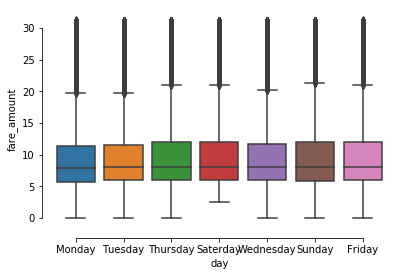

In [125]:
# Boxplot of the month and days_in_from_status_Log
sns.boxplot(x="day", y="fare_amount",
            data=df)
sns.despine(offset=10, trim=True)

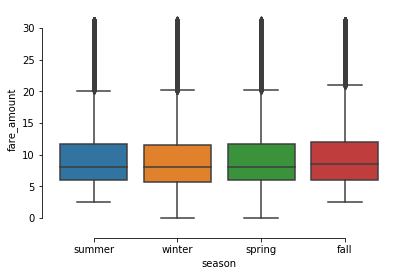

In [126]:
# Boxplot of the month and days_in_from_status_Log
sns.boxplot(x="season", y="fare_amount",
            data=df)
sns.despine(offset=10, trim=True)

-------------------------------------------------------------------------------

### Lon and Lat differnce pickup and dropoff 

In [130]:
df['longitude_difference'] = df['dropoff_longitude'] - df['pickup_longitude']
df['latitude_difference'] = df['dropoff_latitude'] - df['pickup_latitude']

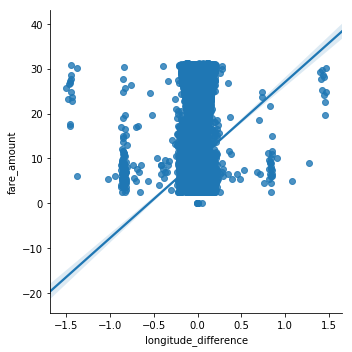

In [133]:
sns.lmplot(x='longitude_difference',y='fare_amount', data=df)

In [135]:
# Correlation
df[['longitude_difference','fare_amount']].corr()

longitude_difference  fare_amount
longitude_difference              1.000000     0.092927
fare_amount                       0.092927     1.000000

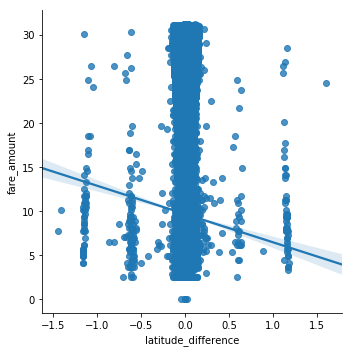

In [134]:
sns.lmplot(x='latitude_difference',y='fare_amount', data=df)

In [136]:
# Correlation
df[['latitude_difference','fare_amount']].corr()

latitude_difference  fare_amount
latitude_difference             1.000000    -0.017819
fare_amount                    -0.017819     1.000000

Both difference features seem to have no correlation with the fare_amount.

### Drop irrelevant features 

In [138]:
# target used for correlation 
target = 'fare_amount'

fare_amount             1.000000
fare_amount_Log         0.953297
dropoff_longitude       0.200457
pickup_longitude        0.119541
longitude_difference    0.092927
dropoff_latitude        0.066733
pickup_latitude         0.054995
month                   0.024990
hour                    0.020243
latitude_difference     0.017819
passenger_count         0.012727
Name: fare_amount, dtype: float64


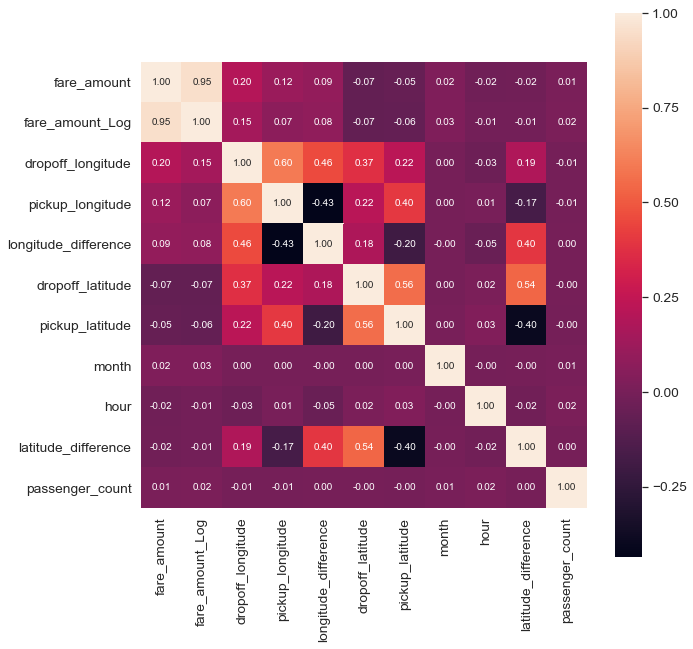

In [141]:
# top ten highest correlated numerical features
nr_feats = 15

corr = df.corr()
corr_abs = corr.abs()
print (corr_abs.nlargest(nr_feats, target)[target])

cols = corr_abs.nlargest(nr_feats, target)[target].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933557 entries, 0 to 999999
Data columns (total 16 columns):
key                     933557 non-null object
fare_amount             933557 non-null float64
pickup_datetime         933557 non-null datetime64[ns]
pickup_longitude        933557 non-null float64
pickup_latitude         933557 non-null float64
dropoff_longitude       933557 non-null float64
dropoff_latitude        933557 non-null float64
passenger_count         933557 non-null int64
fare_amount_Log         933557 non-null float64
month                   933557 non-null int64
day                     933557 non-null object
hour                    933557 non-null int64
dayparts                933557 non-null object
season                  933557 non-null object
longitude_difference    933557 non-null float64
latitude_difference     933557 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(3), object(4)
memory usage: 161.1+ MB


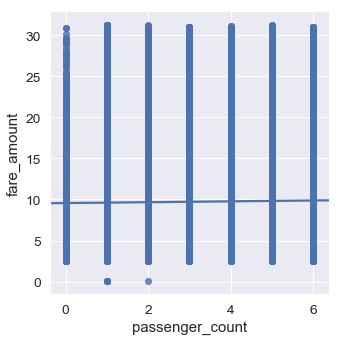

In [142]:
sns.lmplot(x='passenger_count',y='fare_amount', data=df)

In [144]:
# Drop irrelevant features
df_clean = df.drop(['key','pickup_datetime','month','hour','passenger_count','longitude_difference','latitude_difference'],axis=1)

In [145]:
df_clean.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  fare_amount_Log       day   dayparts  season
0          4.5        -73.844311        40.721319         -73.841610         40.712278         1.504077    Monday  afternoon  summer
1         16.9        -74.016048        40.711303         -73.979268         40.782004         2.827314   Tuesday  afternoon  winter
2          5.7        -73.982738        40.761270         -73.991242         40.750562         1.740466  Thursday      night  summer
3          7.7        -73.987130        40.733143         -73.991567         40.758092         2.041220  Saterday      night  spring
4          5.3        -73.968095        40.768008         -73.956655         40.783762         1.667707   Tuesday    morning  spring

# Feature scaling: standardization

After the log-transformation we will apply another feature scaling to all numerical features: standardization with the StandardScaler to bring all features on the same scale.

The standardization will be applied to the following numerical features:

* pickup_longitude
* pickup_latitude
* dropoff_longitude
* dropoff_latitude

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [147]:
scaled_features = scaler.fit_transform(df_clean[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']])
scaled_df = pd.DataFrame(scaled_features, columns=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'])

In [148]:
# Merge scaled_df with normal df on index
df_scaled = pd.merge(scaled_df, df_clean, left_index=True, right_index=True)

In [149]:
df_scaled.drop(['pickup_longitude_y', 'pickup_latitude_y','dropoff_longitude_y', 'dropoff_latitude_y'],axis=1,inplace=True)

In [150]:
df_scaled.head()

pickup_longitude_x  pickup_latitude_x  dropoff_longitude_x  dropoff_latitude_x  fare_amount  fare_amount_Log       day   dayparts  season
0            4.214728          -1.018849             4.182512           -1.219517          4.5         1.504077    Monday  afternoon  summer
1           -1.175630          -1.350626            -0.082639            0.905110         16.9         2.827314   Tuesday  afternoon  winter
2           -0.130120           0.304513            -0.453637           -0.052962          5.7         1.740466  Thursday      night  summer
3           -0.267973          -0.627183            -0.463707            0.176485          7.7         2.041220  Saterday      night  spring
4            0.329484           0.527707             0.617995            0.958678          5.3         1.667707   Tuesday    morning  spring

## Create dummies 

In [151]:
categorical_feats = df_scaled.dtypes[df_scaled.dtypes == "object"].index

In [152]:
categorical_feats

Index(['day', 'dayparts', 'season'], dtype='object')

In [153]:
# Get dummies
df_dummies = pd.get_dummies(df_scaled[['day', 'dayparts', 'season']],drop_first = True)

In [154]:
# Merge with old dataframe
df_scaled = pd.merge(df_dummies, df_scaled, left_index=True, right_index=True)

In [155]:
# Drop non-dummy columns
columns_todrop = ['day', 'dayparts', 'season']
df_scaled.drop(columns_todrop, inplace=True, axis=1)

# Split train-test data

In [156]:
# drop fare_amount
df_scaled.drop('fare_amount',axis=1,inplace=True)

In [157]:
df_scaled.columns

Index(['day_Monday', 'day_Saterday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'dayparts_evening', 'dayparts_morning', 'dayparts_night', 'season_spring', 'season_summer', 'season_winter', 'pickup_longitude_x', 'pickup_latitude_x', 'dropoff_longitude_x', 'dropoff_latitude_x', 'fare_amount_Log'], dtype='object')

In [158]:
X = df_scaled.drop('fare_amount_Log', axis=1)
y = df_scaled['fare_amount_Log']

In [159]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

# Learning & evaluation

In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

### Select a performance measure: Root Mean Square Error 

To measure how a model perform on the test data, we will use a typical performance measure for regression problems: Root Mean Square Error (RMSE). The reason why we will use the RMSE is because RMSE gives a relatively high weight to large errors.

### Nested cross-validation for tuned model comparison

First we will compare different algorithms after tune their hyperparamters by performing a nested cross-validation.

### 1. Linear regression

In [161]:
from sklearn.linear_model import LinearRegression

In [162]:
lr = LinearRegression()

In [163]:
lr_scores = cross_val_score(estimator=lr,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='neg_mean_squared_error')

In [164]:
print('CV performance of Linear Regression: %.3f +/- %.3f' % (np.mean(lr_scores), 
                                      np.std(lr_scores)))

CV performance of Linear Regression: -0.246 +/- 0.001


### 2. Ridge regression

In [55]:
from sklearn.linear_model import Ridge

#### Fine-tune with nested grid search cross validation (10x10) 

In [56]:
ridge = Ridge()
parameters_ridge = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters_ridge, cv=10, verbose=1, scoring = 'neg_mean_squared_error')

In [57]:
scores_ridge = cross_val_score(grid_ridge,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.5min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.4min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.5min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.5min finished


In [58]:
print('CV performance of Ridge Regression: %.3f +/- %.3f' % (np.mean(scores_ridge), 
                                      np.std(scores_ridge)))

CV performance of Ridge Regression: -0.298 +/- 0.002


###  3. Decision Tree

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [60]:
dtr = DecisionTreeRegressor()

In [61]:
dtr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
# cross validation
scores_dtr = cross_val_score(dtr,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

In [63]:
print('CV performance of Decision tree: %.3f +/- %.3f' % (np.mean(scores_dtr), 
                                      np.std(scores_dtr)))

CV performance of Decision tree: -0.624 +/- 0.004


### 4. Random Forest 

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
rf = RandomForestRegressor()

In [66]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [67]:
# cross validation
scores_rf = cross_val_score(rf,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

In [68]:
print('CV performance of Random Forest: %.3f +/- %.3f' % (np.mean(scores_rf), 
                                      np.std(scores_rf)))

CV performance of Random Forest: -0.340 +/- 0.002


### 5. Support Vector Machine 

In [69]:
from sklearn.svm import SVR

In [70]:
svr = SVR()

In [ ]:
svr.fit(X_train,y_train)

In [ ]:
# cross validation
scores_svr = cross_val_score(svr,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)

In [ ]:
print('CV performance of Support Vector Machine: %.3f +/- %.3f' % (np.mean(scores_svm), 
                                      np.std(scores_svm)))

### 6. XG Boost

In [165]:
import xgboost

In [166]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [168]:
xgb_scores = cross_val_score(estimator=xgb,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='neg_mean_squared_error')

In [169]:
print('CV performance of XG Boost Regression: %.3f +/- %.3f' % (np.mean(xgb_scores), 
                                      np.std(xgb_scores)))

CV performance of XG Boost Regression: -0.246 +/- 0.001


## Retrain best model: Linear regression

In [170]:
lr = LinearRegression()

In [171]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [172]:
pred = lr.predict(X_test)

In [177]:
# turn pred into real values
pred_real = np.exp(pred)

In [178]:
# turn y_test into real values
y_test_real = np.exp(y_test)

In [179]:
from sklearn.metrics import mean_squared_error

In [180]:
RMSE = sqrt(mean_squared_error(y_test_real, pred_real))

In [181]:
print("RMSE of final model :" + str(RMSE))

RMSE of final model :5.4744642212339185


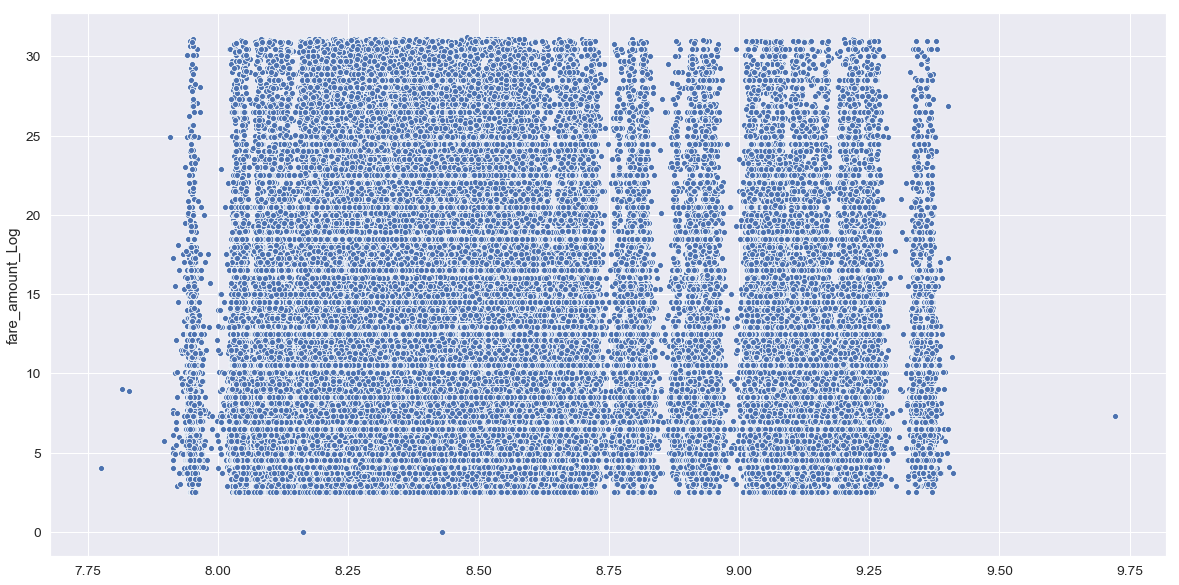

In [182]:
plt.figure(figsize=(20,10))
sns.scatterplot(pred_real,y_test_real)

-------------------------------------------------------------------------------

## Second iteration: less features

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933557 entries, 0 to 999999
Data columns (total 16 columns):
key                     933557 non-null object
fare_amount             933557 non-null float64
pickup_datetime         933557 non-null datetime64[ns]
pickup_longitude        933557 non-null float64
pickup_latitude         933557 non-null float64
dropoff_longitude       933557 non-null float64
dropoff_latitude        933557 non-null float64
passenger_count         933557 non-null int64
fare_amount_Log         933557 non-null float64
month                   933557 non-null int64
day                     933557 non-null object
hour                    933557 non-null int64
dayparts                933557 non-null object
season                  933557 non-null object
longitude_difference    933557 non-null float64
latitude_difference     933557 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(3), object(4)
memory usage: 161.1+ MB


In [187]:
# Drop features
df2 = df.drop(['key','pickup_datetime', 'pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude','passenger_count','month','day','hour','season'],axis=1)

In [188]:
df2.head()

fare_amount  fare_amount_Log   dayparts  longitude_difference  latitude_difference
0          4.5         1.504077  afternoon              0.002701            -0.009041
1         16.9         2.827314  afternoon              0.036780             0.070701
2          5.7         1.740466      night             -0.008504            -0.010708
3          7.7         2.041220      night             -0.004437             0.024949
4          5.3         1.667707    morning              0.011440             0.015754

### Standardization 

In [190]:
scaled_features = scaler.fit_transform(df2[['longitude_difference', 'latitude_difference']])
scaled_df = pd.DataFrame(scaled_features, columns=['longitude_difference', 'latitude_difference'])

In [191]:
# Merge scaled_df with normal df on index
df2_scaled = pd.merge(scaled_df, df2, left_index=True, right_index=True)

In [193]:
df2_scaled.drop(['longitude_difference_y', 'latitude_difference_y'],axis=1,inplace=True)

In [195]:
df2_scaled.head()

longitude_difference_x  latitude_difference_x  fare_amount  fare_amount_Log   dayparts
0                0.024773              -0.311572          4.5         1.504077  afternoon
1                1.214794               2.370340         16.9         2.827314  afternoon
2               -0.366499              -0.367637          5.7         1.740466      night
3               -0.224482               0.831592          7.7         2.041220      night
4                0.329934               0.522342          5.3         1.667707    morning

### Create dummies 

In [196]:
# Get dummies
df2_dummies = pd.get_dummies(df2_scaled['dayparts'],drop_first = True)

In [197]:
# Merge with old dataframe
df2_scaled = pd.merge(df2_dummies, df2_scaled, left_index=True, right_index=True)

In [198]:
# Drop non-dummy columns
df2_scaled.drop('dayparts', inplace=True, axis=1)

### Train-test split 

In [212]:
# drop fare_amount
df2_scaled.drop('fare_amount',axis=1,inplace=True)

KeyError: "labels ['fare_amount'] not contained in axis"

In [213]:
X = df2_scaled.drop('fare_amount_Log', axis=1)
y = df2_scaled['fare_amount_Log']

In [214]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

### Learning and evaluation

In [215]:
lr = LinearRegression()

In [216]:
lr_scores = cross_val_score(estimator=lr,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='neg_mean_squared_error')

In [217]:
print('CV performance of Linear Regression: %.3f +/- %.3f' % (np.mean(lr_scores), 
                                      np.std(lr_scores)))

CV performance of Linear Regression: -0.247 +/- 0.001


### Retrain 

In [218]:
lr = LinearRegression()

In [219]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [220]:
pred = lr.predict(X_test)

In [221]:
# turn pred into real values
pred_real = np.exp(pred)

In [222]:
# turn y_test into real values
y_test_real = np.exp(y_test)

In [223]:
RMSE = sqrt(mean_squared_error(y_test_real, pred_real))

In [225]:
print("RMSE of final model :" + str(RMSE))

RMSE of final model :5.477087754924283
